### Universidad del Valle de Guatemala<br>Data Science<br>Laboratorio6<br>

#### Integrantes:<br>- Christopher García 20541<br>- Andrea Lam 20102

In [1]:
# Se importan librerías
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torchvision.utils import save_image
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

### Se accede a Kaggle para obtener datos

In [2]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:13<00:00, 187MB/s]
100% 1.33G/1.33G [00:13<00:00, 105MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Se crea una semilla para poder reproducir el modelo

In [8]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [9]:
# Se definen variables globales para la generación del conjunto de datos
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 40
lr = 0.0005
beta1 = 0.5
ngpu = 1

Dispositivo utilizado: cuda:0


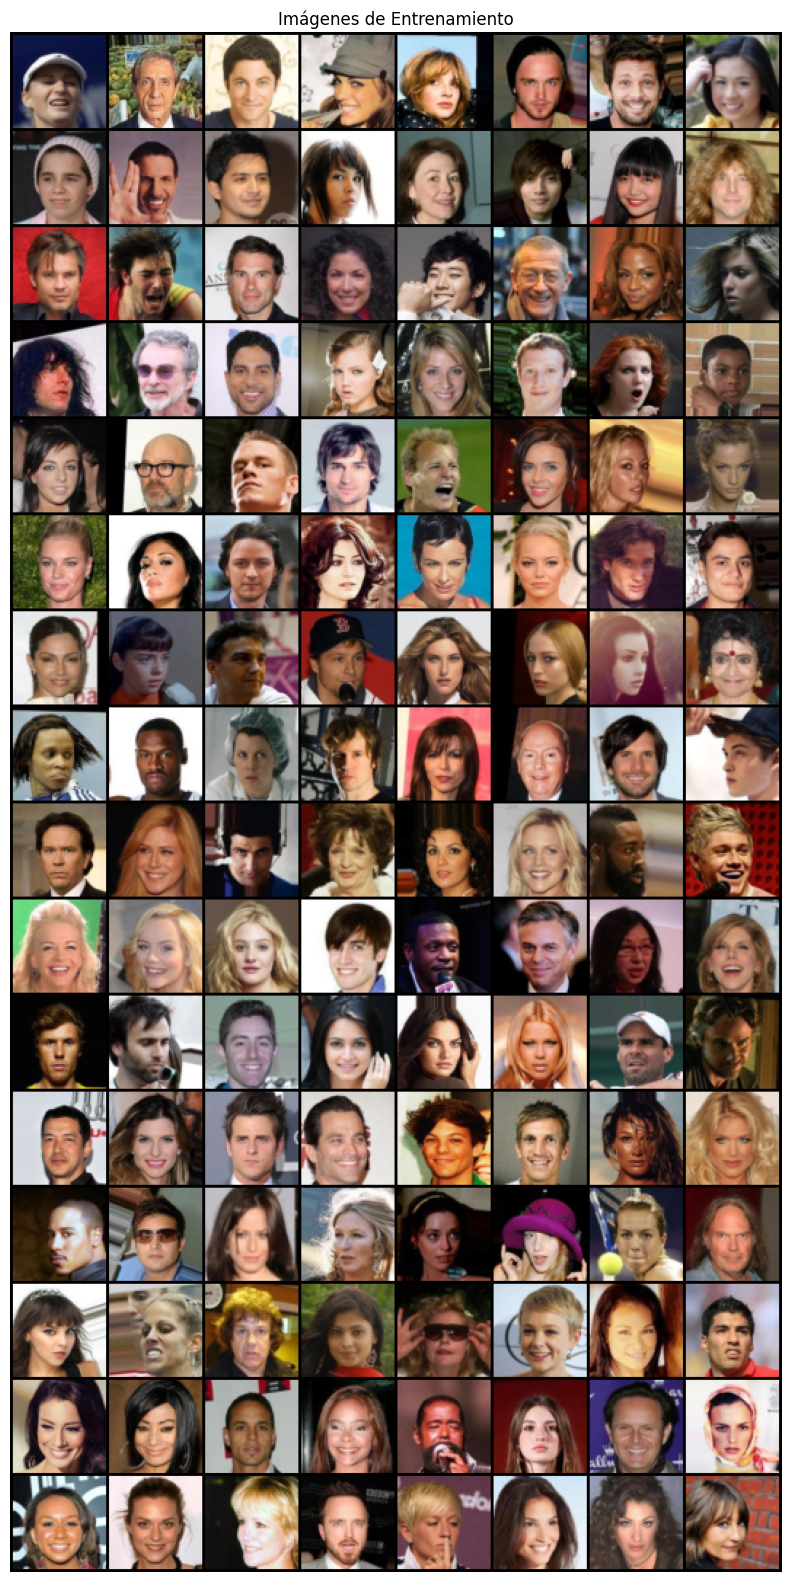

In [10]:
dataset = dset.ImageFolder(root="./img_align_celeba", transform=transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(f"Dispositivo utilizado: {device}")

real_batch = next(iter(dataloader))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Imágenes de Entrenamiento")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [12]:
# Definir la arquitectura del generador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Definir la arquitectura del discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Crear instancias del generador y el discriminador
netG = Generator().to(device)
netD = Discriminator().to(device)

In [14]:
# Imprimir la arquitectura de ambas redes
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4,

In [15]:
# Definir el optimizador para el generador y el discriminador
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Definir la función de pérdida (criterio) para el GAN
criterion = nn.BCELoss()

# Etiquetas para la discriminación de imágenes reales y generadas
real_label = 1.0
fake_label = 0.0

# Entrenamiento del GAN
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
       ## Entrenar con lote completamente real
        netD.zero_grad()
        # Formatear el lote
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Pasada hacia adelante del lote real a través de D
        output = netD(real_cpu).view(-1)
        # Calcular la pérdida en el lote completamente real
        errD_real = criterion(output, label)
        # Calcular los gradientes para D en la pasada hacia atrás
        errD_real.backward()
        D_x = output.mean().item()

        # Generar imágenes falsas y actualizar el discriminador
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Actualizar el generador
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Imprimir estadísticas
        if i % 100 == 0:
            print(f'Época [{epoch}/{num_epochs}] Lote [{i}/{len(dataloader)}]'
                  f' Loss D: {errD.item():.4f} Loss G: {errG.item():.4f}'
                  f' D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    # Guardar imágenes generadas al final de cada época
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        save_image(fake, f'gan_generated_epoch_{epoch}.png')

ValueError: ignored

In [ ]:
tamanio_tanda = 32